In [1]:
import numpy as np

In [2]:
from numba import int32, float32, float64, njit, boolean, prange
from numba.experimental import jitclass


In [3]:
import matplotlib.pyplot as plt

In [4]:
rng = np.random.default_rng(12345)

In [5]:
@njit()
def rand_choice_nb(arr, prob):
    return arr[np.searchsorted(np.cumsum(prob), np.random.random(), side="right")]

In [6]:
mabSpec = [
    ("k", int32),
    ("epsilon", float32),
    ("alpha", float32),
    ("constantStep", boolean),
    ("n", int32),
    ("Q", float64[:]),
    ("start", float32)
]


@jitclass(mabSpec)
class MultiArmedBandit:
    def __init__(self, k, epsilon, constantStep=False, alpha=0.1, start=0):
        self.k = k
        self.epsilon = epsilon
        self.constantStep = constantStep
        self.alpha = alpha
        self.Q = np.ones(k) * start
        self.n = 1

    def sample(self, rewards):
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.k)
        else:
            action = np.flatnonzero(self.Q == np.max(self.Q))
            action = np.random.choice(action) if len(action) > 1 else action[0]
        r = rewards[action]
        self.Q[action] = self.updateQ(r, action)
        return r

    def updateQ(self, reward, action):
        self.n += 1
        updateTerm = 1 / self.n if self.constantStep else self.alpha
        return self.Q[action] + updateTerm * (reward - self.Q[action])


In [7]:
ucbSpec = [
    ("k", int32),
    ("Nt", float64[:]),
    ("c", float32),
    ("alpha", float32),
    ("constantStep", boolean),
    ("n", int32),
    ("Q", float64[:]),
]


@jitclass(ucbSpec)
class UCB:
    def __init__(self, k, c, alpha, constantStep=False):
        self.k = k
        self.c = c
        self.alpha = alpha
        self.constantStep = constantStep
        self.Q = np.zeros(k)
        self.n = 1
        self.Nt = np.ones(k) * 0.00000000000000000001

    def sample(self, rewards):
        action = np.argmax(self.Q + (self.c * np.sqrt(np.log(self.n) / self.Nt)))
        r = rewards[action]
        self.Q[action] = self.updateQ(r, action)
        return r

    def updateQ(self, reward, action):
        self.n += 1
        self.Nt[action] += 1
        updateTerm = 1 / self.n if self.constantStep else self.alpha
        return self.Q[action] + updateTerm * (reward - self.Q[action])


In [8]:
gbSpec = [
    ("k", int32),
    ("R_avg", float32),
    ("alpha", float32),
    ("n", int32),
    ("constantStep", boolean),
    ("H", float64[:]),
    ("p", float64[:]),
]


@jitclass(gbSpec)
class GradientBandit:
    def __init__(self, k, alpha, constantStep=False):
        self.k = k
        self.alpha = alpha
        self.constantStep = constantStep
        self.H = np.ones(k)
        self.p = np.ones(k) / k
        self.n = 1
        self.k = k
        self.R_avg = 0

    def sample(self, rewards):
        self.p = self._p()
        action = rand_choice_nb(np.arange(self.k), self.p)
        r = rewards[action]
        self.R_avg += self.updateR(r)
        self.updateH(action, r)
        return r

    # Instead of estimating Q values we are directly updating parameters w.r.t. a gradient signal    
    def updateH(self, action, reward):
        self.H[action] += self.alpha * (reward - self.R_avg) * (1 - self.p[action])
        self.H[:action] -= self.alpha * (reward - self.R_avg) * self.p[:action]
        self.H[action + 1:] -= self.alpha * (reward - self.R_avg) * self.p[action + 1:]
        

    def updateR(self, reward):
        self.n += 1
        updateTerm = 1 / self.n if self.constantStep else self.alpha
        return updateTerm * (reward - self.R_avg)

    def _p(self):
        return np.exp(self.H) / np.sum(np.exp(self.H))

In [9]:
@njit()
def run_experiments(k, n, epochs):

    rewards_sample_averages = np.empty((n, epochs))
    rewards_step_size = np.empty((n, epochs))
    rewards_ucb = np.empty((n, epochs))
    rewards_gb = np.empty((n, epochs))
    rewards_oa = np.empty((n, epochs))

    epsilon = 0.1
    alpha= 0.1
    c = 2
    for i in range(n):

        R = np.ones(k) * 4

        alphaBandit = MultiArmedBandit(k, epsilon, False, alpha, 0)
        averageBandit = MultiArmedBandit(k, epsilon, True, alpha, 0)
        optimisticAlpha = MultiArmedBandit(k, epsilon, False, alpha, 1)
        ucb = UCB(k, c, alpha, False)
        gb = GradientBandit(k, 0.00005, False)

        for j in range(epochs):

            rewards_step_size[i, j] = alphaBandit.sample(R)
            rewards_sample_averages[i, j] = averageBandit.sample(R)
            rewards_ucb[i, j] = ucb.sample(R)
            rewards_gb[i, j] = gb.sample(R)
            rewards_oa[i, j] = optimisticAlpha.sample(R)
            R = R + np.random.normal(loc=0,scale=1, size=k)

    lastBandits = (alphaBandit, averageBandit, ucb, gb, optimisticAlpha, R)
    
    return rewards_step_size, rewards_sample_averages, rewards_ucb, rewards_gb, rewards_oa, lastBandits

In [19]:
k = 10
epochs = 10000
n = 100



rewards_step_size, rewards_sample_averages, rewards_ucb, rewards_gb, rewards_oa, lastBandits = run_experiments(k, n, epochs)


rewards_sample_averages = np.mean(rewards_sample_averages, axis = 0)
rewards_step_size = np.mean(rewards_step_size , axis = 0)
rewards_ucb = np.mean(rewards_ucb , axis = 0)   
rewards_gb = np.mean(rewards_gb , axis = 0)
rewards_oa = np.mean(rewards_oa , axis = 0)

In [20]:
alphaBandit, averageBandit, ucb, gb, optimisticAlpha, R = lastBandits

In [21]:
averageBandit.Q 

array([ 4.01034018e+01, -3.23373326e-01,  1.46119675e+00, -7.32976233e-01,
        3.86994330e-02,  4.77404762e-01,  1.35279144e+00, -1.14866193e+00,
       -8.35477680e-01,  1.68752172e+00])

In [22]:
alphaBandit.Q

array([ 142.48424165,  -52.83074877,  -38.91600897,  -46.1950694 ,
        -72.19785267,  -58.98408354,  128.45257368, -186.56059641,
        108.22472004,   24.07328621])

In [23]:
ucb.Q

array([  0.60605879,   0.60611628,   0.56553254,   3.74779413,
         4.50118106,   0.26760365, 139.43538635,   4.3162376 ,
         0.45697511,   4.27874654])

In [24]:
optimisticAlpha.Q

array([ 134.41329164,  -54.68950928,  -31.22460486,  -46.36177164,
        -71.346142  ,  -60.56663302,  139.43679103, -174.3104154 ,
        105.81426341,   24.62765227])

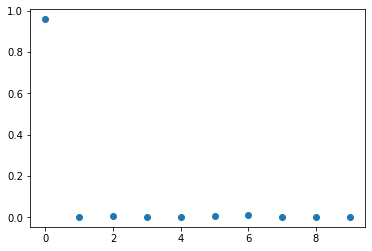

In [25]:
plt.plot(gb.p, 'o')

In [26]:
R

array([ 143.59750975,  -56.62980852,  -14.35396813,  -58.34730239,
        -73.0981835 ,  -98.12126825,  140.95024172, -163.67042221,
        135.99723431,   68.67194945])

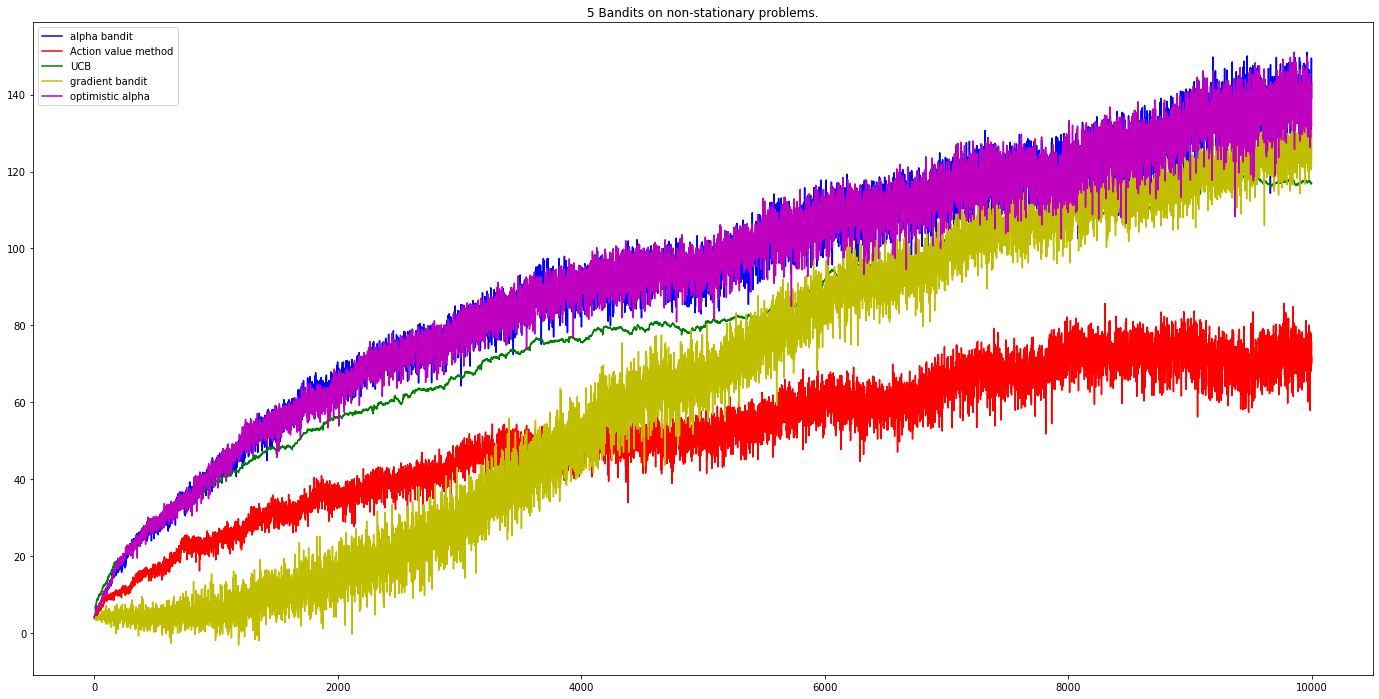

In [27]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(24,12))
ax.set_title("5 Bandits on non-stationary problems.")
ax.plot(rewards_step_size, '-b')
ax.plot( rewards_sample_averages, 'r-')
ax.plot(rewards_ucb, '-g')    
ax.plot(rewards_gb, '-y')
ax.plot(rewards_oa, 'm-')
ax.legend(["alpha bandit", "Action value method", "UCB", "gradient bandit", "optimistic alpha"]);
